# Notebook : Exploration & Nettoyage des données

## 1️⃣ Introduction
- **Objectif** : Explorer le dataset d’images satellites et leurs annotations pour identifier anomalies et statistiques.
- **Description des fichiers** :
  - `_annotations.coco.json` → annotations au format COCO
  - Dossier `images/` → images satellites


## 2️⃣ Chargement des données
- Lire le fichier `_annotations.coco.json`
- Créer des DataFrames pour :
  - `images` → informations sur chaque image
  - `annotations` → informations sur les objets annotés
  - `categories` → liste des catégories

In [66]:
# 2️⃣ Chargement des données

# lire le fichier _annotations.coco.json et créer des DataFrames
import json
import pandas as pd

# Chemin vers le fichier d'annotations
annotations_file = "data/_annotations.coco.json"

# Charger le fichier JSON
with open(annotations_file, "r") as f:
    coco_data = json.load(f) #load() lit le fichier JSON et le convertit en dictionnaire Python

# Convertir en DataFrames  pandas (faciliter)
images_df = pd.DataFrame(coco_data["images"])
annotations_df = pd.DataFrame(coco_data["annotations"])
categories_df = pd.DataFrame(coco_data["categories"])

# Vérifier les premières lignes
images_df.head(), annotations_df.head(), categories_df.head()


(   id  license                                          file_name  height  \
 0   0        1  cl6e1qges001kgk555z158f33_2_FALSE_COLOR_jpg.rf...     860   
 1   1        1  cl6kgm9qr002yc455g5qs87kz_2_FALSE_COLOR_jpg.rf...     860   
 2   2        1  cl6odzs5e002oao55heuig0a6_1_TRUE_COLOR_jpg.rf....     860   
 3   3        1  cl6b6pieh007rl455fwvb73gr_1_TRUE_COLOR_jpg.rf....     860   
 4   4        1  cl6b5k38g003zl455bgtd1317_4_FALSE_COLOR__URBAN...     860   
 
    width              date_captured  \
 0   1200  2025-09-14T12:06:19+00:00   
 1   1200  2025-09-14T12:06:19+00:00   
 2   1200  2025-09-14T12:06:19+00:00   
 3   1200  2025-09-14T12:06:19+00:00   
 4   1200  2025-09-14T12:06:19+00:00   
 
                                                extra  
 0  {'name': 'cl6e1qges001kgk555z158f33_2_FALSE_CO...  
 1  {'name': 'cl6kgm9qr002yc455g5qs87kz_2_FALSE_CO...  
 2  {'name': 'cl6odzs5e002oao55heuig0a6_1_TRUE_COL...  
 3  {'name': 'cl6b6pieh007rl455fwvb73gr_1_TRUE_COL...  
 4  {'na

## 3️⃣ Exploration des données
- Nombre total d’images
- Nombre total d’annotations
- Quelles sont les catégories
- Nombre d’images par catégorie
- Statistiques sur le nombre d’annotations par image

In [64]:

# 3️⃣ Exploration des données

# Compter le nombre total d'images et d'annotations(annotation: les objets dans les images)
print("Nombre total d'images :", len(images_df))
print("Nombre total d'annotations :", len(annotations_df))



Nombre total d'images : 500
Nombre total d'annotations : 959


In [8]:

# Nombre d'images par catégorie
# Joindre annotations et catégories
annotations_with_cat = annotations_df.merge(categories_df, left_on='category_id', right_on='id', how='left')
images_per_category = annotations_with_cat.groupby('name')['image_id'].nunique()
print(images_per_category)


name
fire    493
Name: image_id, dtype: int64


In [ ]:
# Statistiques sur le nombre d'annotations par image (combien d'objets par image, en moyenne, min, max,std: écart-type (c a dire la dispersion des D par rapport à la moyenne)
annotations_count = annotations_df.groupby('image_id').size()
print(annotations_count.describe())

count    493.000000
mean       1.945233
std        1.405218
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       10.000000
dtype: float64


## 4️⃣ Vérification des incohérences
- Images sans annotations
- Annotations sans image correspondante
- Valeurs aberrantes dans les annotations (ex : largeur ou hauteur = 0)

In [ ]:

# 4️⃣ Vérification des incohérences

import pandas as pd

# 1️ Images sans annotations
images_with_annotations = annotations_df['image_id'].unique() # .unique: obtenir les valeurs uniques
images_no_annotations = images_df[~images_df['id'].isin(images_with_annotations)] # ~ : négation, isin: vérifier si l'id de l'image est dans la liste des images avec annotations
print("Images sans annotations :", len(images_no_annotations))
print(images_no_annotations[['id', 'file_name']].head())


Images sans annotations : 7
      id                                          file_name
0      0  cl6e1qges001kgk555z158f33_2_FALSE_COLOR_jpg.rf...
96    96  cl6kf5xzo000gc4552qc8hhcc_2_FALSE_COLOR_jpg.rf...
118  118  cl6e2kygp002egk55asrs2brz_1_TRUE_COLOR_jpg.rf....
122  122  cl6e3enfn003sgk554uim9wo6_1_TRUE_COLOR_jpg.rf....
209  209  cl6kfx47x001tc45578ts0yz6_2_FALSE_COLOR_jpg.rf...


In [ ]:
# --- Images avec annotations partielles ---

from collections import Counter

def images_with_partial_annotations(coco_data, min_annotations=1):
    """
    Retourne les images qui ont moins que 'min_annotations' annotations.
    
    Args:
        coco_data (dict): Les données COCO.
        min_annotations (int): Nombre minimum d'annotations pour considérer qu'une image est complète.
        
    Returns:
        List[dict]: Liste des images avec annotations partielles.
    """
    # Compter les annotations par image
    img_count = Counter([ann['image_id'] for ann in coco_data['annotations']])
    
    # Filtrer les images avec moins de min_annotations
    partial_images = [img for img in coco_data['images'] if img_count.get(img['id'], 0) < min_annotations]
    
    return partial_images


# Images avec moins de 3 annotations
images_less_3 = images_with_partial_annotations(coco_data, min_annotations=3)
print(f"Nombre d'images avec moins de 3 annotations : {len(images_less_3)}")
print([img['file_name'] for img in images_less_3]) # les noms de fichiers des images avec moins de 3 annotations

Nombre d'images avec moins de 3 annotations : 386
['cl6e1qges001kgk555z158f33_2_FALSE_COLOR_jpg.rf.479904c9e54c6ba121689341598bf3ed.jpg', 'cl6kgm9qr002yc455g5qs87kz_2_FALSE_COLOR_jpg.rf.95debd80b7509cc0a6afe0a7c7ff6cfe.jpg', 'cl6b6pieh007rl455fwvb73gr_1_TRUE_COLOR_jpg.rf.8f3f9c84272e40682f7f430cdc4ac4c0.jpg', 'cl6b5k38g003zl455bgtd1317_4_FALSE_COLOR__URBAN_jpg.rf.fcaa4827b85c1b38fdedffcd6a3b098f.jpg', 'cl6cswt5400gdl4554rn2gjz9_1_TRUE_COLOR_jpg.rf.e410a3d52182432dc9d14d9b24b69cb0.jpg', 'cl6op0cny006bao55hefn0jyf_2_FALSE_COLOR_jpg.rf.de2937d7380d94b2a24472a7744afe9b.jpg', 'cl6op9m80006sao552sp0bgyl_2_FALSE_COLOR_jpg.rf.bee0f2e3b76eaaae3f5309ba40f22e89.jpg', 'cl6ch417300btl4554l143qop_4_FALSE_COLOR__URBAN_jpg.rf.43e72d2d74427093db9424b5a3eae89a.jpg', 'cl6cg6cf600agl455gtin273p_2_FALSE_COLOR_jpg.rf.3c95193dd276836b31dc3df24f29e351.jpg', 'cl6m10x9x00348w55h67q3hes_2_FALSE_COLOR_jpg.rf.746f55b2cb2a94835ebbb485b3715504.jpg', 'cl6kga3590029c455dfqjh4v7_2_FALSE_COLOR_jpg.rf.ef13360dbca3f541099

In [ ]:

# 2️ Annotations sans image correspondante
annotations_no_image = annotations_df[~annotations_df['image_id'].isin(images_df['id'])]
print("Annotations sans image :", len(annotations_no_image))
print(annotations_no_image.head())


Annotations sans image : 0
Empty DataFrame
Columns: [id, image_id, category_id, bbox, area, segmentation, iscrowd, bbox_width, bbox_height]
Index: []


In [14]:

# 3️ Valeurs aberrantes : largeur ou hauteur = 0 dans bbox (bbox: [x, y, width, height] c'est la boîte englobante de l'objet dans l'image)
# Extraire largeur et hauteur depuis la colonne 'bbox'
annotations_df['bbox_width'] = annotations_df['bbox'].apply(lambda x: x[2])
annotations_df['bbox_height'] = annotations_df['bbox'].apply(lambda x: x[3])

invalid_annotations = annotations_df[(annotations_df['bbox_width'] == 0) | 
                                    (annotations_df['bbox_height'] == 0)]
print("Annotations invalides (bbox_width=0 ou bbox_height=0) :", len(invalid_annotations))
print(invalid_annotations.head())


Annotations invalides (bbox_width=0 ou bbox_height=0) : 0
Empty DataFrame
Columns: [id, image_id, category_id, bbox, area, segmentation, iscrowd, bbox_width, bbox_height]
Index: []


In [ ]:
# 4 Vérification des bounding boxes hors limites des images

# Joindre annotations avec infos images (pour avoir width/height)
ann_with_img = annotations_df.merge(
    images_df[["id", "width", "height"]],
    left_on="image_id",
    right_on="id",
    suffixes=("_ann", "_img")
)

# Extraire les coordonnées bbox
ann_with_img["x_min"] = ann_with_img["bbox"].apply(lambda b: b[0])
ann_with_img["y_min"] = ann_with_img["bbox"].apply(lambda b: b[1])
ann_with_img["x_max"] = ann_with_img.apply(lambda row: row["bbox"][0] + row["bbox"][2], axis=1)
ann_with_img["y_max"] = ann_with_img.apply(lambda row: row["bbox"][1] + row["bbox"][3], axis=1)

# Vérification des conditions
invalid_bboxes = ann_with_img[
    (ann_with_img["x_min"] < 0) |
    (ann_with_img["y_min"] < 0) |
    (ann_with_img["x_max"] > ann_with_img["width"]) |
    (ann_with_img["y_max"] > ann_with_img["height"])
]

print("Nombre de bounding boxes hors limites :", len(invalid_bboxes))
if len(invalid_bboxes) > 0:
    display(invalid_bboxes[["image_id", "bbox", "width", "height", "x_min", "y_min", "x_max", "y_max"]].head())
else:
    print(" Toutes les bounding boxes sont bien à l'intérieur des images.")


Nombre de bounding boxes hors limites : 44


,image_id,bbox,width,height,x_min,y_min,x_max,y_max
51,25,"[922, 677, 278.29, 183.13]",1200,860,922,677,1200.29,860.13
82,43,"[1129, 357, 71.06, 93.99]",1200,860,1129,357,1200.06,450.99
102,50,"[549, 736, 425.24, 124.33]",1200,860,549,736,974.24,860.33
105,52,"[864, 562, 336.06, 251.45]",1200,860,864,562,1200.06,813.45
112,55,"[512, 569, 144.66, 291.25]",1200,860,512,569,656.66,860.25


In [28]:
# 5 Détection de doublons

# Convertir la colonne bbox (list) en tuple pour permettre la détection de doublons
annotations_df['bbox_tuple'] = annotations_df['bbox'].apply(tuple)

# Identifier les doublons basés sur image_id, bbox_tuple et category_id
duplicates = annotations_df[annotations_df.duplicated(subset=["image_id", "bbox_tuple", "category_id"], keep=False)]

print("Nombre d'annotations dupliquées :", len(duplicates))
if len(duplicates) > 0:
    display(duplicates.sort_values(["image_id", "category_id"]).head(10))
else:
    print(" Aucune annotation dupliquée détectée.")


Nombre d'annotations dupliquées : 0
 Aucune annotation dupliquée détectée.


## 5️⃣ Visualisation
- Affichage d’exemples d’images avec les bounding boxes
- Vérification visuelle de la cohérence entre images et annotations


### 5/1: Répartition des annotations par image

But : vérifier si la majorité des images contiennent peu ou beaucoup d’objets.
Pour comprendre la distribution et d’identifier les cas extrêmes.


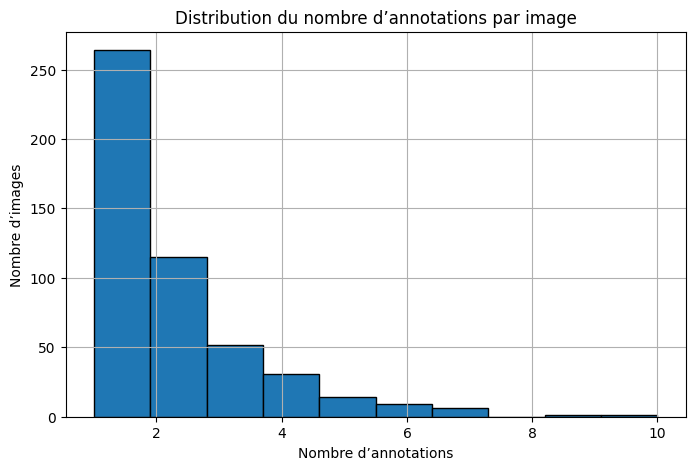

In [41]:
# 5️-1 Visualisation de la répartition du nombre d’annotations par image
import matplotlib.pyplot as plt

annotations_per_image = annotations_df['image_id'].value_counts()

plt.figure(figsize=(8,5))
annotations_per_image.hist(bins=10, edgecolor="black")
plt.title("Distribution du nombre d’annotations par image")
plt.xlabel("Nombre d’annotations")
plt.ylabel("Nombre d’images")
plt.show()

### 5/2 : Répartition des images selon les annotations  

**But :** Identifier la proportion d’images bien annotées, partiellement annotées et sans annotations, afin de décider si certaines doivent être supprimées ou corrigées.  


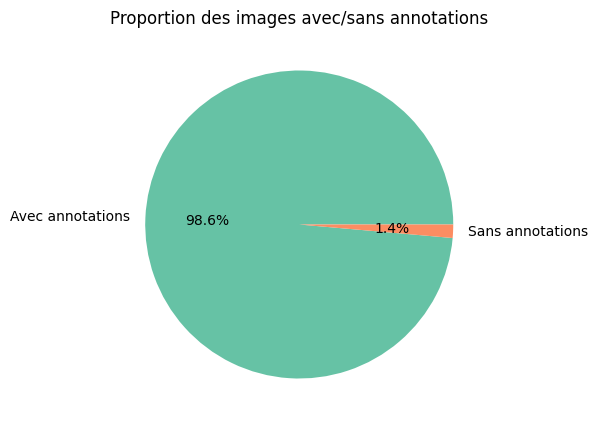

In [42]:
with_ann = len(images_df) - len(images_no_annotations)
without_ann = len(images_no_annotations)

plt.figure(figsize=(5,5))
plt.pie([with_ann, without_ann], labels=["Avec annotations", "Sans annotations"],
        autopct="%1.1f%%", colors=["#66c2a5", "#fc8d62"])
plt.title("Proportion des images avec/sans annotations")
plt.show()


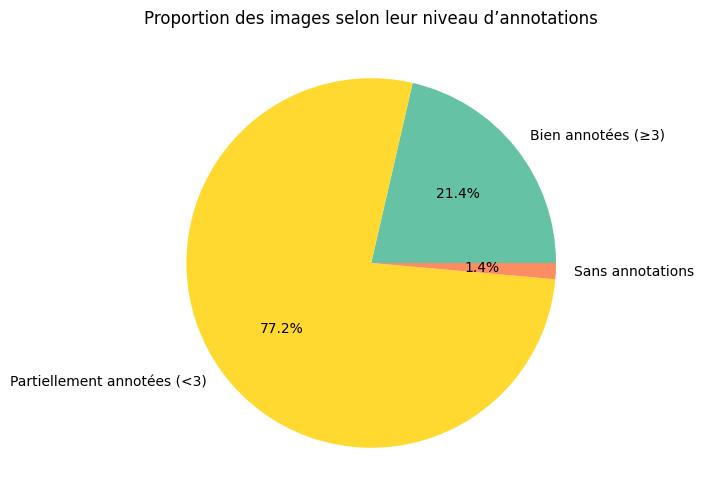

In [ ]:
# Comptages 
with_ann = len(images_df) - len(images_no_annotations)
without_ann = len(images_no_annotations)
partial_ann = len(images_less_3)   

# Graphique
plt.figure(figsize=(6,6))
plt.pie(
    [with_ann - partial_ann, partial_ann, without_ann], 
    labels=["Bien annotées (≥3)", "Partiellement annotées (<3)", "Sans annotations"],
    autopct="%1.1f%%", 
    colors=["#66c2a5", "#ffd92f", "#fc8d62"]
)
plt.title("Proportion des images selon leur niveau d’annotations")
plt.show()


### 5/3: Distribution de la taille des bounding boxes

But : détecter les bounding boxes trop petites ou trop grandes
qui pourraient être des anomalies.


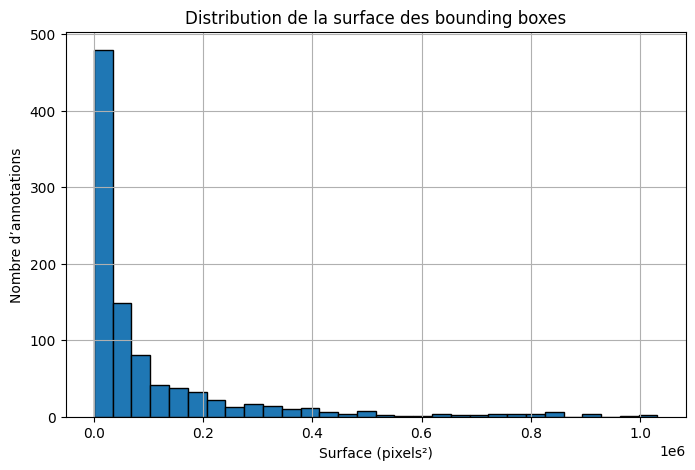

In [ ]:
plt.figure(figsize=(8,5))
annotations_df["area"].hist(bins=30, edgecolor="black")
plt.title("Distribution de la surface des bounding boxes")
plt.xlabel("Surface (pixels²)")
plt.ylabel("Nombre d’annotations")
plt.show()


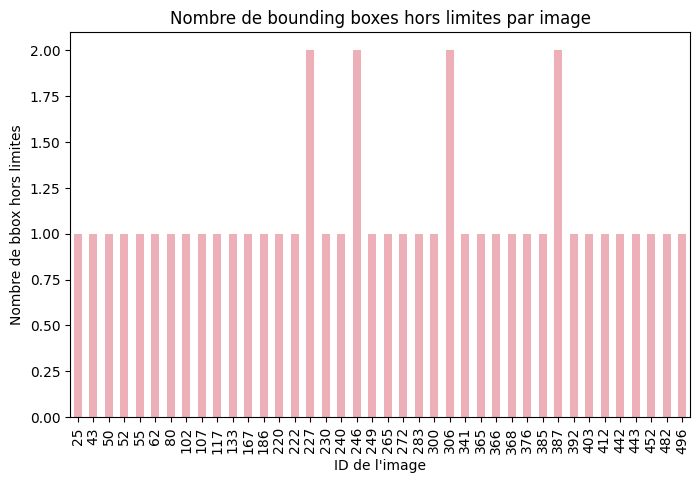

In [43]:
#5/4 du nombre de bbox hors limites par image
# Comptage du nombre de bbox hors limites par image
bbox_out_of_bounds_count = invalid_bboxes.groupby("image_id").size()

# Histogramme
plt.figure(figsize=(8,5))
bbox_out_of_bounds_count.plot(kind="bar", color="#EDAFB8")
plt.title("Nombre de bounding boxes hors limites par image")
plt.xlabel("ID de l'image")
plt.ylabel("Nombre de bbox hors limites")
plt.show()

## 6️⃣ Nettoyage et préparation
Lors de l’exploration, plusieurs problèmes ont été identifiés :  
- **Images sans annotations** (7 cas) → inutilisables, donc on peut le supprimées.  
- **Images avec moins de 3 annotations** (386 cas) → choix de les conserver pour éviter une perte trop importante de données.  
- **Bounding boxes invalides (hors limites)** on a  choisi de **corriger les coordonnées** des bbox (clip aux dimensions de l’image). pour  conserver un maximum de données valides tout en garantissant la cohérence géométrique.  

**Justification du choix :**  
L’approche adoptée privilégie la **conservation maximale** des données utiles.


On a 44 bbox invalides (x_max ou y_max qui dépassent la taille de l’image).
La solution recommandée est de clipper (recadrer) les bbox à l’intérieur de l’image, pour eviter de les supprimer les annotations.

## 7️⃣ Tests
- Tester les fonctions d’exploration et de nettoyage sur quelques images/annotations
- Préparer les tests unitaires pour `data_explorer.py` et `data_cleaner.py`